# Trend Following Strategy with MA

This strategy is very similar to [Clenow-trend-following.ipynb](./Clenow-trend-following.ipynb), the only difference is that it uses MA crossover instead of breakout as entry rule.

In [1]:
%matplotlib inline

from typing import Dict, List, Tuple, Union

import os
import multiprocessing
from tqdm.contrib.concurrent import process_map 
import backtrader as bt
import pandas as pd
from dask import bag as db
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

## 1. Reading Data

In [2]:
BAR_SIZE = 180000 # 3 minute
TIME_BAR_DIR = f'/data/bars/TimeBar/{BAR_SIZE}'

In [3]:
from utils import read_bars

In [4]:
time_bars = read_bars(f'/data/bars/TimeBar/{BAR_SIZE}/TimeBar.{BAR_SIZE}.Binance.Swap.BTC_USDT.csv')

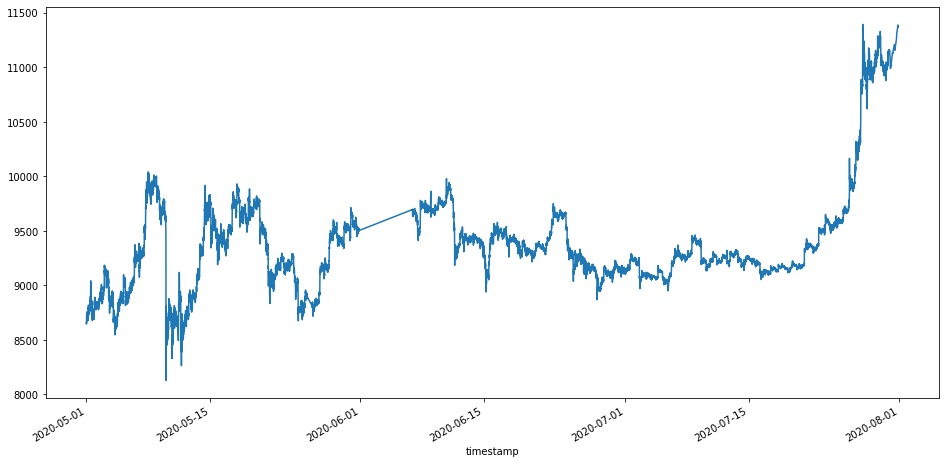

In [5]:
time_bars['vwap'].plot(figsize=(16, 8))

**They look almost the same!! There must be some cointegration.**

## 2. The Strategy

In [6]:
class ClenowTrendFollowingStrategy(bt.Strategy):
    """The trend following strategy from the book "Following the trend" by Andreas Clenow."""
    alias = ('ClenowTrendFollowing',)

    params = (
        ('trend_filter_fast_period', 50),
        ('trend_filter_slow_period', 100),
        # period for the fast Moving Average
        ('fast', 10),
        # period for the slow moving average
        ('slow', 40),
        ('trailing_stop_atr_period', 100),
        ('trailing_stop_atr_count', 3),
        ('risk_factor', 0.002)
    )

    def __init__(self):
        self.trend_filter_fast = bt.indicators.EMA(period=self.params.trend_filter_fast_period)
        self.trend_filter_slow = bt.indicators.EMA(period=self.params.trend_filter_slow_period)
        self.ema_fast = bt.indicators.EMA(period=self.params.fast)
        self.ema_slow = bt.indicators.EMA(period=self.params.slow)
        self.atr = bt.indicators.ATR(period=self.params.trailing_stop_atr_period, movav=bt.indicators.EMA)
        self.order = None  # the pending order
        # For trailing stop loss
        self.sl_order = None # trailing stop order
        self.sl_price = None
        self.max_price = None
        self.min_price = None

    def next(self):
        if not self.position: # Entry rules
            assert self.position.size == 0
            
            # Position size rule
            max_loss = self.broker.get_cash() * self.p.risk_factor # cash you afford to loss
            position_size = max_loss / self.atr[0]

            if self.ema_fast > self.ema_slow:
                if self.trend_filter_fast > self.trend_filter_slow: # trend filter
                    if self.order:
                        self.broker.cancel(self.order)
                    else:
                        # Entry rule 1
                        self.order = self.buy(price=self.data.close[0], size=position_size, exectype=bt.Order.Limit) 
                        self.max_price = self.data.close[0]
            elif self.ema_fast < self.ema_slow:
                if self.trend_filter_fast  < self.trend_filter_slow: # trend filter
                    if self.order:
                        self.broker.cancel(self.order)
                    else:
                        # Entry rule 2
                        self.order = self.sell(price=self.data.close[0], size=position_size, exectype=bt.Order.Limit) 
                        self.min_price = self.data.close[0]
        else:
            assert self.position.size
            # assert self.order is None

            # Exit rules
            if self.position.size > 0:
                # Exit rule 1
                if self.ema_fast < self.ema_slow:
                    self.order = self.order_target_value(target=0.0, exectype=bt.Order.Limit, price=self.data.close[0])
                    return
            else:
                # Exit rule 2
                if self.ema_fast > self.ema_slow:
                    self.order = self.order_target_value(target=0.0, exectype=bt.Order.Limit, price=self.data.close[0])
                    return

            # Trailing stop loss
            trail_amount = self.atr[0] * self.p.trailing_stop_atr_count
            if self.position.size > 0:
                self.max_price = self.data.close[0] if self.max_price is None else max(self.max_price, self.data.close[0])
                if self.sl_price is None or self.sl_price < self.max_price - trail_amount:
                    self.sl_price = self.max_price - trail_amount # increase trailing price
                    if self.sl_order:
                        self.broker.cancel(self.sl_order)
                    else:
                        self.sl_order = self.order_target_value(target=0.0, exectype=bt.Order.Stop, price=self.sl_price)
            elif self.position.size < 0:
                self.min_price = self.data.close[0] if self.min_price is None else min(self.min_price, self.data.close[0])
                if self.sl_price is None or self.sl_price > self.min_price + trail_amount:
                    self.sl_price = self.min_price + trail_amount # decrease trailing price
                    if self.sl_order:
                        self.broker.cancel(self.sl_order)
                    else:
                        self.sl_order = self.order_target_value(target=0.0, exectype=bt.Order.Stop, price=self.sl_price)

    def notify_order(self, order):
        if order.status in [order.Created, order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # print logs here

        # Write down: no pending order
        if order.exectype == bt.Order.Stop:
            self.sl_order = None
        else:
            self.order = None

## 3. Running the strategy

In [7]:
LEVERAGE = 1 # No leverage in backtesting
BINANCE_SWAP_TAKER_FEE = 0.0004
INITIAL_CASH = 20000.0 # dollars

In [8]:
from utils import CryptoSpotCommissionInfo, CryptoContractCommissionInfo, CryptoPandasData

def strategy_demo():
    cerebro = bt.Cerebro(maxcpus=1)
    cerebro.addstrategy(ClenowTrendFollowingStrategy)

    data_feed = CryptoPandasData(dataname=time_bars, timeframe=bt.TimeFrame.Minutes, compression=BAR_SIZE//(1000*60), name='Binance-Swap-BTC_USDT')
    cerebro.adddata(data_feed)

    cerebro.broker.setcash(INITIAL_CASH)
    # https://www.backtrader.com/blog/posts/2016-12-06-shorting-cash/shorting-cash/
    cerebro.broker.set_shortcash(False)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.broker.addcommissioninfo(CryptoContractCommissionInfo(commission=BINANCE_SWAP_TAKER_FEE, mult=LEVERAGE))

    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, compression=1, factor=365, annualize=True)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.Returns, timeframe=bt.TimeFrame.Days, compression=1, tann=365)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, data=data_feed, _name='buyandhold')

    results = cerebro.run()
    assert len(results) == 1

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print(f'Number of trades: {results[0].analyzers.ta.get_analysis().total.total}')
    print('PnL: %.2f' % (results[0].analyzers.ta.get_analysis().pnl.net.total,))
    print('PnL: %.2f' % (cerebro.broker.getvalue()-INITIAL_CASH,))
    print('Sharpe Ratio: ', results[0].analyzers.sharperatio.get_analysis()['sharperatio'])
    print('CAGR: %.2f%%' % (results[0].analyzers.returns.get_analysis()['ravg'] * 100,))
    print('Total return: %.2f%%' % (list(results[0].analyzers.timereturn.get_analysis().values())[0] * 100,))
    print('Max Drawdown: %.2f%%' % results[0].analyzers.drawdown.get_analysis().max.drawdown)
    print('Buy and Hold: {0:.2f}%'.format(list(results[0].analyzers.buyandhold.get_analysis().values())[0] * 100))

    plt.rcParams['figure.figsize'] = (16, 8)
    cerebro.plot(iplot=False)

    return results[0]

Starting Portfolio Value: 20000.00
Final Portfolio Value: 15831.40
Number of trades: 301
PnL: -4135.98
PnL: -4168.60
Sharpe Ratio:  -3.377359641368982
CAGR: -0.27%
Total return: -20.84%
Max Drawdown: 26.13%
Buy and Hold: 31.83%


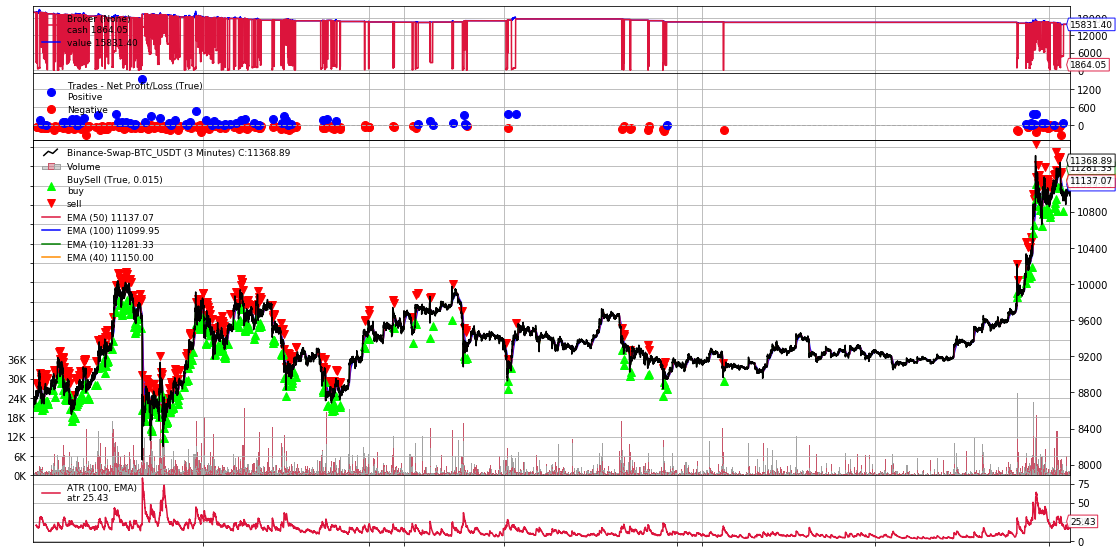

In [9]:
result = strategy_demo()

**This strategy doesn't beat the Buy&Hold benchmark, next step we're going to optimize its parameters.**

## 4. Searching for Optimal Parameters with Backtesting

In [10]:
def run_strategy(
    params: Dict[str, Union[float, int]] = {
        'trend_filter_fast_period': 50,
        'trend_filter_slow_period': 100,
        'fast': 25,
        'slow': 50,
        'trailing_stop_atr_period': 100,
        'trailing_stop_atr_count': 3,
        'risk_factor': 0.002
    }
):
    cerebro = bt.Cerebro(maxcpus=1)
    cerebro.addstrategy(ClenowTrendFollowingStrategy, 
                        trend_filter_fast_period=params['trend_filter_fast_period'],
                        trend_filter_slow_period = params['trend_filter_slow_period'],
                        fast = params['fast'],
                        slow = params['slow'],
                        trailing_stop_atr_period = params['trailing_stop_atr_period'],
                        trailing_stop_atr_count = params['trailing_stop_atr_count'],
                        risk_factor = params['risk_factor'])

    data_feed = CryptoPandasData(dataname=time_bars, timeframe=bt.TimeFrame.Minutes, compression=BAR_SIZE//(1000*60), name='Binance-Swap-BTC_USDT')
    cerebro.adddata(data_feed)

    cerebro.broker.setcash(INITIAL_CASH)
    # https://www.backtrader.com/blog/posts/2016-12-06-shorting-cash/shorting-cash/
    cerebro.broker.set_shortcash(False)

    cerebro.broker.addcommissioninfo(CryptoContractCommissionInfo(commission=BINANCE_SWAP_TAKER_FEE, mult=LEVERAGE))

    cerebro.addsizer(bt.sizers.PercentSizer, percents=100)

    cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, compression=1, factor=365, annualize=True)
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addanalyzer(bt.analyzers.Returns, timeframe=bt.TimeFrame.Days, compression=1, tann=365)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.NoTimeFrame, data=data_feed, _name='buyandhold')

    results = cerebro.run()
    assert len(results) == 1

    stats = {
        # 'PnL': list(results[0].analyzers.timereturn.get_analysis().values())[0],
        'PnL': cerebro.broker.getvalue()/INITIAL_CASH-1,
        'BnH': list(results[0].analyzers.buyandhold.get_analysis().values())[0],
        'Sharpe_Ratio': results[0].analyzers.sharperatio.get_analysis()['sharperatio'],
        'CARG': results[0].analyzers.returns.get_analysis()['ravg'],
        'Max_Drawdown': results[0].analyzers.drawdown.get_analysis().max.drawdown/100,
        'num_trades': results[0].analyzers.ta.get_analysis().total.total,
    }
    return {**params, **stats}

In [11]:
def grid_search()->pd.DataFrame:
    params_list = []
    
    for fast in range(16, 64):
        for m1 in range(2, 6):
            for m2 in range(2, 6):
                for atr_count in [2, 4, 8]:
                    params = {
                    'trend_filter_fast_period': fast * m1,
                    'trend_filter_slow_period': fast * m1 * m2,
                    'fast': fast,
                    'slow': fast * m1,
                    'trailing_stop_atr_period': fast * m1 * m2,
                    'trailing_stop_atr_count': atr_count,
                    'risk_factor': 0.002
                    }
                    params_list.append(params)

#     with ProgressBar(): # Backtrader is not compatible with Dask ???
#         stats = db.from_sequence(params_list).map(run_strategy).compute()

#     with multiprocessing.Pool(os.cpu_count()) as p:
#         stats = p.map(run_strategy, params_list)

    stats = process_map(run_strategy, params_list, max_workers=os.cpu_count())
    
    df = pd.DataFrame(stats)
    df.sort_values('Sharpe_Ratio', ascending=False, inplace=True)
    return df

In [12]:
df = grid_search()

In [13]:
df

,trend_filter_fast_period,trend_filter_slow_period,fast,slow,trailing_stop_atr_period,trailing_stop_atr_count,risk_factor,PnL,BnH,Sharpe_Ratio,CARG,Max_Drawdown,num_trades
1331,172,860,43,172,860,8,0.002,0.178370,0.318345,2.101311,0.001887,0.173546,44
2039,174,870,58,174,870,8,0.002,0.187624,0.318345,2.039209,0.001976,0.184019,47
1282,168,840,42,168,840,4,0.002,0.212599,0.318345,1.996358,0.002216,0.150346,79
1005,180,900,36,180,900,2,0.002,0.203556,0.318345,1.889035,0.002130,0.138886,88
2037,174,870,58,174,870,2,0.002,0.199761,0.318345,1.872527,0.002093,0.145974,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,32,96,16,32,96,8,0.002,-0.249337,0.318345,-4.157670,-0.003297,0.291328,229
150,38,152,19,38,152,2,0.002,-0.261822,0.318345,-4.179505,-0.003489,0.317091,334
151,38,152,19,38,152,4,0.002,-0.250784,0.318345,-4.301126,-0.003319,0.305664,237
96,36,72,18,36,72,2,0.002,-0.285671,0.318345,-4.335365,-0.003867,0.312331,413


In [14]:
df.sort_values('PnL', ascending=False)

,trend_filter_fast_period,trend_filter_slow_period,fast,slow,trailing_stop_atr_period,trailing_stop_atr_count,risk_factor,PnL,BnH,Sharpe_Ratio,CARG,Max_Drawdown,num_trades
1282,168,840,42,168,840,4,0.002,0.212599,0.318345,1.996358,0.002216,0.150346,79
1006,180,900,36,180,900,4,0.002,0.204425,0.318345,1.821754,0.002138,0.166025,67
1005,180,900,36,180,900,2,0.002,0.203556,0.318345,1.889035,0.002130,0.138886,88
2037,174,870,58,174,870,2,0.002,0.199761,0.318345,1.872527,0.002093,0.145974,88
2038,174,870,58,174,870,4,0.002,0.197560,0.318345,1.784442,0.002072,0.168706,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,34,68,17,34,68,2,0.002,-0.258255,0.318345,-3.707131,-0.003434,0.286869,434
150,38,152,19,38,152,2,0.002,-0.261822,0.318345,-4.179505,-0.003489,0.317091,334
192,40,80,20,40,80,2,0.002,-0.266392,0.318345,-3.978717,-0.003561,0.302534,379
96,36,72,18,36,72,2,0.002,-0.285671,0.318345,-4.335365,-0.003867,0.312331,413


## References

* [Orders - Backtrader](https://www.backtrader.com/docu/order/)
* [Trading Cryptocurrency Fractional Sizes in backtrader](https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/)
* [Shorting the cash - Backtrader](https://www.backtrader.com/blog/posts/2016-12-06-shorting-cash/shorting-cash/)
* [Commission Schemes - Backtrader](https://www.backtrader.com/docu/commission-schemes/commission-schemes/)
* [Difference between leverage and multi - Backtrader Community](https://community.backtrader.com/topic/729/difference-between-leverage-and-multi)
* [Forex trading leverage settings in backtrader - Backtrader Community](https://community.backtrader.com/topic/1309/forex-trading-leverage-settings-in-backtrader)
* [How to initialize bt.analyzers.SharpeRatio? - Backtrader Community](https://community.backtrader.com/topic/2747/how-to-initialize-bt-analyzers-sharperatio)
* [How to close current position at the end of backtest? - Backtrader Community](https://community.backtrader.com/topic/1156/how-to-close-current-position-at-the-end-of-backtest)